# **Retrieval Augmented Generation (RAG) Primer**

Modern Large Language Models (LLMs) are often limited by their lack of specific knowledge and a cut-off period for their training, usually resulting in hallucinations. RAG is an approach in which personalized context can be provided to LLMs to improve their factual accuracy on specific domains. This allows the user to carry out generative tasks using the LLM on custom data without fine-tuning or altering the existing knowledge base of the LLM.

A basic RAG pipeline is demonstrated below.

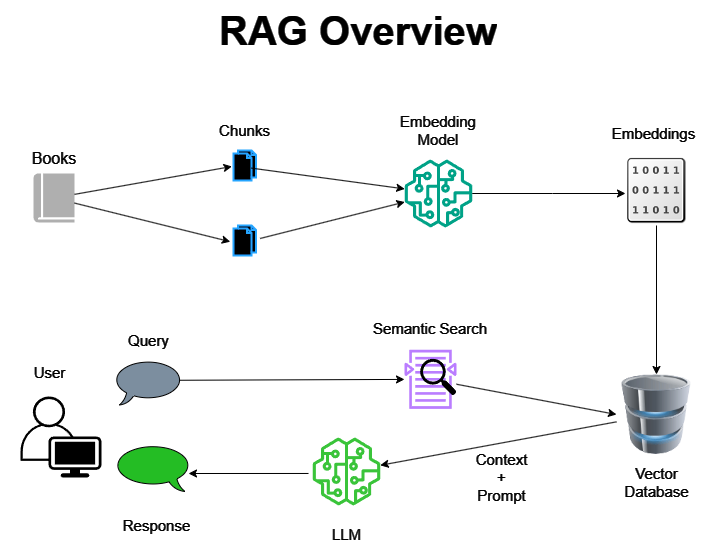

**[LangChain](https://www.langchain.com/) is used as the chosen framework for this notebook. Other frameworks such as Llamaindex can be used as well.**

In [1]:
#install necessary libraries
!pip install -q torch transformers transformers accelerate bitsandbytes langchain pypdf sentence-transformers faiss-gpu openpyxl langchain-community ipython-autotime langchain-huggingface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.2/396.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/

In [2]:
#useful for keeping track of time

%load_ext autotime

time: 1.64 ms (started: 2024-09-01 16:24:03 +00:00)


In [3]:
#necessary imports

from google.colab import drive
import os
from getpass import getpass
import numpy as np

import langchain
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.llms import HuggingFaceHub
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEndpoint

from langchain.chains import RetrievalQA
from langchain.chains import ConversationalRetrievalChain
from langchain_core.prompts import PromptTemplate
from langchain_core.prompts.chat import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

from langchain.chains import (
    create_history_aware_retriever,
    create_retrieval_chain,
)
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage


time: 5.99 s (started: 2024-09-01 16:24:03 +00:00)


# **Indexing**

Following any data preparation step on the documents, they need to be chunked into smaller segments and their corresponding embeddings have to be generated.

In [5]:
#mount drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 11.1 s (started: 2024-09-01 16:26:34 +00:00)


## **Load PDF and Chunk**

In [6]:
#PDF or directory path
pdf_name = 'Bangladesh A Legacy of Blood.pdf'
pdf_path = '/content/drive/MyDrive/BanglaRAG/' + pdf_name

time: 710 µs (started: 2024-09-01 16:28:32 +00:00)


In [7]:
#load the PDF
#for txt files, use TextLoader
#for multiple files in a directory, use DirectoryLoader (REQUIRES TROUBLESHOOTING)

loader = PyPDFLoader(pdf_path)
documents = loader.load()

time: 10.7 s (started: 2024-09-01 16:28:33 +00:00)


In [8]:
#check the content of the loaded document

documents[7].page_content

"  Bangladesh A Legacy of Blood;  Copyright  ©  www.sanipanhwar.com                            4 \n privilege to i nspect personally. The dialogue, whenever used,  is a faithful reproduction \nof the words which my informants said they actual ly used during the events in which \nthey were involved. Thus majors Farook and Rashid tell the authentic story of the Why \nand the How of the killing of Sh eikh M ujib: and the mystery is revealed of the slaughter \nof hapless Tajuddin and his companions in Dhak a jail by the men who planned and \nexecuted it. General Zia is exposed by his friends and his critics. His assassins tell how \nthey killed him. And throughout the narrative of the wasted blood of  the Bangladesh \nmartyrs cries out the lesson  that when hope is extinguished,  accountability denied and \nthe peop le have nothing further to lose,  they turn to violence to redress their wrongs.  \n \nShakespeare said: 'The evil that men do lives after them. The good is oft interred with \

time: 2.96 ms (started: 2024-09-01 16:28:44 +00:00)


In [9]:
#check number of documents/chunks and characters before splitting

avg_char_in_docs = sum([len(doc.page_content) for doc in documents]) / len(documents)

time: 987 µs (started: 2024-09-01 16:28:50 +00:00)


In [10]:
print(f"Total chunks: {len(documents)}. Average characters per chunk {avg_char_in_docs}")

Total chunks: 251. Average characters per chunk 2825.370517928287
time: 1.08 ms (started: 2024-09-01 16:28:50 +00:00)


## Chunking

In order to fit the context window/length of the LLM as well for our embedding model, the documents need to be split into smaller 'chunks'. The size of each chunk can depend on the choice of these models or some statistic of the documents used.

Smaller chunks are also useful for better semantic search as the query from the user is compared to a smaller part of the document everytime.

In [11]:
#Split into chunks
#Size, Overlap and Length functions are important paramenters
#Reliant on Embedding model and LLM context window as well

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap  = 20,
)

time: 672 µs (started: 2024-09-01 16:28:56 +00:00)


In [12]:
chunks = text_splitter.split_documents(documents)

time: 53.8 ms (started: 2024-09-01 16:28:57 +00:00)


In [13]:
#Check chunks and size again
avg_char_in_docs = sum([len(doc.page_content) for doc in chunks]) / len(chunks)
print(f"Total chunks: {len(chunks)}. Average characters per chunk {avg_char_in_docs}")

Total chunks: 1667. Average characters per chunk 421.8476304739052
time: 1.94 ms (started: 2024-09-01 16:28:57 +00:00)


## Embedding

Embeddings are numerical representations of text in the form of vectors which capture the semantic information of the text. This also allows further computation on these vectors. Fine-tuned embedding models can be used to generate embeddings of a given text.

Load an appropriate (language, purpose etc.) embedding model from HuggingFace. The Embedding leaderboard can be used as reference.
https://huggingface.co/spaces/mteb/leaderboard

In [14]:
#load huggingface embedding model.
#Set appropriate device and other parameters

hf_embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-en-v1.5",
    model_kwargs={'device':'cpu'},
    encode_kwargs={'normalize_embeddings': True}
)

<ipython-input-14-b6aabb99d302>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  hf_embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as s

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

time: 22.4 s (started: 2024-09-01 16:29:06 +00:00)


In [15]:
#check embedding dimension
chunk_index = 0
test_embedding = np.array(hf_embeddings.embed_query(chunks[chunk_index].page_content))
print(f"Embedding of Chunk {chunk_index}: {test_embedding}.\n Shape of embedding: {test_embedding.shape}")

Embedding of Chunk 0: [-5.76769523e-02  1.34466097e-01  3.54584958e-03  4.38148994e-03
  6.43625809e-03  9.42940358e-03 -3.48816626e-02  7.37602822e-03
 -2.38468461e-02  3.83919738e-02  3.60153220e-03 -6.51826933e-02
 -5.99586442e-02 -8.19480885e-03 -2.49496270e-02  3.64728384e-02
  4.12159227e-03  1.52096888e-02 -4.77263369e-02 -5.66874351e-03
 -8.13470222e-03  1.89381484e-02  5.32802306e-02 -2.94439346e-02
  3.96106578e-02  5.83855389e-03  2.89169909e-03 -3.72760780e-02
 -7.68009275e-02 -1.86011598e-01 -4.08685347e-03 -4.15877029e-02
  1.54796569e-03  6.38391543e-03 -5.47127910e-02  1.95353944e-03
 -3.00265271e-02  4.99103256e-02  3.27292867e-02 -1.20819313e-02
  3.04350145e-02  3.66583690e-02  7.20962696e-03  2.21889205e-02
 -8.02931190e-02  2.30270457e-02  5.91675863e-02  1.80493537e-02
  4.31316830e-02 -6.74411608e-03 -2.45453697e-02  3.47149521e-02
  4.51115072e-02  1.63114537e-02  5.17240446e-03 -4.40567993e-02
 -2.25167023e-03  4.58985530e-02 -5.48984669e-03  1.24465590e-02
  4

##Vector Database
Once embeddings are generated, a vector database can be used to store and index them along with the chunks. This also helps to not generate the embeddings every time.

Initialize a Vector database of choice to index embeddings and retrieve them. FAISS (Facebook AI Similiarity Search) is being used here as an example as it generally provides good results using a basic retriever.

In [16]:
#Initialize the vector DB

vector_db = FAISS.from_documents(chunks, hf_embeddings)

time: 3min 26s (started: 2024-09-01 16:29:34 +00:00)


In [17]:
#Save DB locally if needed. Can be loaded on a different session

vector_db_path = '/content/drive/MyDrive/BanglaRAG/vector_store'
vector_db.save_local(vector_db_path)

time: 60 ms (started: 2024-09-01 16:33:00 +00:00)


In [18]:
#Test with a simple similarity search with parameters.
#k sets the number of relevant chunks retrieved.
#A lower score indicates better similarity

test_query = "What date was Bangladesh born?"

time: 1.01 ms (started: 2024-09-01 16:33:00 +00:00)


In [19]:
answers = vector_db.similarity_search_with_score(test_query, k=5)

time: 39.3 ms (started: 2024-09-01 16:33:00 +00:00)


In [20]:
#Check the answers and scores from similarity search

for answer in answers:
  print(f"Retrieved chunk: {answer[0].page_content} \nSimilarity score: {answer[1]}\n")

Retrieved chunk: Bangladesh A Legacy of Blood;  Copyright  ©  www.sanipanhwar.com                            3 
  
PREFACE  
 
 
This is a true story;  in many ways a text book of Third World disenchantmen t. 
 
On the 1 6th of December, 1971, the state of Bangladesh (population 70.000,000) was 
born at the end of a nine -month liberation struggle in which more than a million 
Bengalis of the erstwhile East Pakistan died at the hands of the Pakistan army. But one 
Similarity score: 0.4879271388053894

Retrieved chunk: state. Nevertheless on this grey  wint er's morning Raza ul Karim,  the acting head of the 
London Mission, was quietly informing Sheikh Mujibur Rahman of the new role that 
destiny had designed for him.  
 
It was a li ttle after 9 am on 8 January, 1 972, a Saturday, exactly 23 days after the formal 
birth of Bangladesh was achieved by the surrender of 93,000 Pakistani troops to the 
Indian army in Dhaka. President Zulfik ar Ali Bhutto, who only a few days earlier had 
S

# Retriever

Initialize a retrieval strategy. Langchain provides ParentDocumentRetriever, MultiQueryRetriever, EnsembleRetriever etc. These retrievers also need additional changes e.g., new chunking or LLM initialization. For simplicity, the base retriever is used here with a similarity search.

In [21]:
#k is the number of relevant chunks to retrieve from our vector DB

retriever = vector_db.as_retriever(search_kwargs = {"k": 5})

time: 853 µs (started: 2024-09-01 16:33:37 +00:00)


In [88]:
#Other retrival strategies
#ParentDocumentRetriever, MultiQueryRetriever, EnsembleRetriever etc.

time: 424 µs (started: 2024-08-31 20:18:55 +00:00)


# Large Language Model

An LLM, fitting the task and resources, is required to generate the final output. The LLM benchmark on HuggingFace can be used accordingly.
https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard

An Access token is required from HF which needs to be set up as an environment variable.
https://huggingface.co/docs/hub/security-tokens

In [ ]:
os.environ['HUGGINGFACEHUB_API_TOKEN'] = getpass()

In [107]:
llm = HuggingFaceEndpoint(
    endpoint_url="https://api-inference.huggingface.co/models/HuggingFaceH4/zephyr-7b-beta",
    max_new_tokens= 1024,
    temperature= 0.1,
)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
time: 121 ms (started: 2024-09-01 18:35:45 +00:00)


# Generation

The context from retriever needs to be sent to the LLM along with a prompt for a response to the query. Langchain provides several methods to achieve this pipeline. Two methods are highlighted here. **RetrievalQA** gives a base response to a query while **ConversationalRetrievalChain** provides a chatbot like interface.

In [143]:
#Create a langchain prompt template
#Langchain fills the input_variables in the prompt
#The context will be filled with our retrieved relevant chunks
#The question will be filled with the user's query

prompt_template = """ONLY use the following context to answer the question at the end. CAREFULLY follow the following rules:
1. If you don't know the answer, just say that you don't know, don't try to make up an answer.
2. If you don't find the answer in the context, say "Not present in context".
3. DO NOT write anything else other than the answer.


Context: {context}

Question: {question}

Answer:
"""

prompt = PromptTemplate(template=prompt_template,
                        input_variables=["context", "question"])

time: 906 µs (started: 2024-09-01 18:44:08 +00:00)


In [144]:
#To monitor the pipeline

langchain.verbose = True

time: 518 µs (started: 2024-09-01 18:44:09 +00:00)


In [145]:
#Langchain creates the RAG pipeline using the LLM, retrierver and the prompt
#'stuffing' basically concatenates all relevant chunks
#source documents can be checked

rag_QA = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt}
)

time: 4.73 ms (started: 2024-09-01 18:44:09 +00:00)


In [146]:
#query for RAG
query = "What date was Bangladesh born?"

time: 541 µs (started: 2024-09-01 18:44:09 +00:00)


In [147]:
#The final prompt sent to the LLM can be viewed here

result = rag_QA.invoke({"query": query})



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
ONLY use the following context to answer the question at the end. CAREFULLY follow the following rules:
1. If you don't know the answer, just say that you don't know, don't try to make up an answer.
2. If you don't find the answer in the context, say "Not present in context".
3. DO NOT write anything else other than the answer.


Context: Bangladesh A Legacy of Blood;  Copyright  ©  www.sanipanhwar.com                            3 
  
PREFACE  
 
 
This is a true story;  in many ways a text book of Third World disenchantmen t. 
 
On the 1 6th of December, 1971, the state of Bangladesh (population 70.000,000) was 
born at the end of a nine -month liberation struggle in which more than a million 
Bengalis of the erstwhile East Pakistan died at the hands of the Pakistan army. But one

state. Nevertheless on this grey  wint er's morning Raza ul Kar

In [148]:
print(result['result'])


The state of Bangladesh was born on December 16, 1971, at the end of a nine-month liberation struggle in which more than a million Bengalis of the erstwhile East Pakistan died at the hands of the Pakistan army. (Bangladesh A Legacy of Blood; Copyright © www.sanipanhwar.com, page 3)
time: 473 µs (started: 2024-09-01 18:44:11 +00:00)


In [60]:
#Check the returned context from retriever

for doc in result['source_documents']:
  print(f"Source:{doc.metadata['source']}\nPage:{doc.metadata['page']}\nContent:{doc.page_content}")
  print("---" * 20)

Source:/content/drive/MyDrive/BanglaRAG/Bangladesh A Legacy of Blood.pdf
Page:6
Content:Bangladesh A Legacy of Blood;  Copyright  ©  www.sanipanhwar.com                            3 
  
PREFACE  
 
 
This is a true story;  in many ways a text book of Third World disenchantmen t. 
 
On the 1 6th of December, 1971, the state of Bangladesh (population 70.000,000) was 
born at the end of a nine -month liberation struggle in which more than a million 
Bengalis of the erstwhile East Pakistan died at the hands of the Pakistan army. But one
------------------------------------------------------------
Source:/content/drive/MyDrive/BanglaRAG/Bangladesh A Legacy of Blood.pdf
Page:13
Content:state. Nevertheless on this grey  wint er's morning Raza ul Karim,  the acting head of the 
London Mission, was quietly informing Sheikh Mujibur Rahman of the new role that 
destiny had designed for him.  
 
It was a li ttle after 9 am on 8 January, 1 972, a Saturday, exactly 23 days after the formal 
birth of

In [149]:
query = "What was Mahboobul Alam's profession and how much was he paid for his work?"

result = rag_QA.invoke({"query": query})

print(result['result'])



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
ONLY use the following context to answer the question at the end. CAREFULLY follow the following rules:
1. If you don't know the answer, just say that you don't know, don't try to make up an answer.
2. If you don't find the answer in the context, say "Not present in context".
3. DO NOT write anything else other than the answer.


Context: year wrote scripts for Radio Pakistan's PLAIN TR UTH programme  - a highly colored 
propaganda or disinformation effort aimed at the Bangladeshi freedom struggle. For 
this he was paid between Rs 30 and Rs 50 per piece, about £4 at the prevailing rate of 
exchange. After the liberation of Bangladesh Mahboobu l Alam found himself both 
without a job and covered with the odium of having betrayed the freedom movement

by backing the wrong side. But instead of being locked up in j ail on charges of 
collaboration,

In [62]:
#Check the returned context from retriever

for doc in result['source_documents']:
  print(f"Source:{doc.metadata['source']}\nPage:{doc.metadata['page']}\nContent:{doc.page_content}")
  print("---" * 20)

Source:/content/drive/MyDrive/BanglaRAG/Bangladesh A Legacy of Blood.pdf
Page:26
Content:year wrote scripts for Radio Pakistan's PLAIN TR UTH programme  - a highly colored 
propaganda or disinformation effort aimed at the Bangladeshi freedom struggle. For 
this he was paid between Rs 30 and Rs 50 per piece, about £4 at the prevailing rate of 
exchange. After the liberation of Bangladesh Mahboobu l Alam found himself both 
without a job and covered with the odium of having betrayed the freedom movement
------------------------------------------------------------
Source:/content/drive/MyDrive/BanglaRAG/Bangladesh A Legacy of Blood.pdf
Page:26
Content:by backing the wrong side. But instead of being locked up in j ail on charges of 
collaboration,  as another journal ist writing for PLAIN TRUTH was,  Mah boobul Alam 
wangled a job, of all things, as Prime Minister Mujibur Rahman's press officer. But 
because of the stink it created even Mujib had to get rid of him. It must make the 
Bangla

In [150]:
query = "Who is George Washington?"

result = rag_QA.invoke({"query": query})

print(result['result'])



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
ONLY use the following context to answer the question at the end. CAREFULLY follow the following rules:
1. If you don't know the answer, just say that you don't know, don't try to make up an answer.
2. If you don't find the answer in the context, say "Not present in context".
3. DO NOT write anything else other than the answer.


Context: local garrison commander. The excuse given was that the President was making a 
purely political visit and he did not want the GOC to be involved in it. But Manzoor 
took the instructions as a calculated public snub. Indeed, he had good reason to feel so.  
The other military commanders would be on hand as usual. Rear Admiral M. A. Khan, 
the Chief of Naval Staff whose principal base was at Chittagong, was expressly

General Ershad, the Deputy Chief of Army Staff, General Manzoor, the CGS. General 
Mir Shaukat

In [151]:
query = "Who is Abraham Lincoln?"

result = rag_QA.invoke({"query": query})

print(result['result'])



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
ONLY use the following context to answer the question at the end. CAREFULLY follow the following rules:
1. If you don't know the answer, just say that you don't know, don't try to make up an answer.
2. If you don't find the answer in the context, say "Not present in context".
3. DO NOT write anything else other than the answer.


Context: Abu Taher, who led the Sepoy Mutiny in November, 1975, and was subsequently 
hanged by Zia. The other is retired Lt. Colonel Mohammad Ziauddin, the legendary 
underground leader of the Sharbohara ( Maoist) Party. All three were majors at that 
time and even then Manzoor was ins ufferably arrogant. An Indian  government officer 
who received Manzoor and his companions at Jammu and escorted them by train first 
to New Delhi and then to Calcutta, vividl y remembered how Manzoor threw a tantrum

Demands. This was 

In [126]:
#Check the returned context from retriever

for doc in result['source_documents']:
  print(f"Source:{doc.metadata['source']}\nPage:{doc.metadata['page']}\nContent:{doc.page_content}")
  print("---" * 20)

Source:/content/drive/MyDrive/BanglaRAG/Bangladesh A Legacy of Blood.pdf
Page:213
Content:local garrison commander. The excuse given was that the President was making a 
purely political visit and he did not want the GOC to be involved in it. But Manzoor 
took the instructions as a calculated public snub. Indeed, he had good reason to feel so.  
The other military commanders would be on hand as usual. Rear Admiral M. A. Khan, 
the Chief of Naval Staff whose principal base was at Chittagong, was expressly
------------------------------------------------------------
Source:/content/drive/MyDrive/BanglaRAG/Bangladesh A Legacy of Blood.pdf
Page:174
Content:General Ershad, the Deputy Chief of Army Staff, General Manzoor, the CGS. General 
Mir Shaukat Ali, the commander  of the 9th Division, and the Navy and Air Force chiefs
------------------------------------------------------------
Source:/content/drive/MyDrive/BanglaRAG/Bangladesh A Legacy of Blood.pdf
Page:150
Content:to appoint hi m Ch

## Conversational Chain

In [287]:
#First create prompt to maintain history
#Create new history retriever

contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, just "
    "reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("user", "{input}"),
    ]
)

history_aware_retriever = create_history_aware_retriever(
    llm=llm, retriever=retriever, prompt=contextualize_q_prompt
)

time: 4.38 ms (started: 2024-08-31 23:50:22 +00:00)


In [313]:
# Answer question
qa_system_prompt = (
"""ONLY use the following pieces of context to answer the question at the end. CAREFULLY follow the following rules:
1. If you don't know the answer, just say that you don't know, don't try to make up an answer.
2. ALWAYS start your answer with "Alola!!"

{context}

""")

time: 863 µs (started: 2024-08-31 23:56:23 +00:00)


In [314]:
#Original prompt to get answers

qa_prompt = ChatPromptTemplate.from_messages([
("system", qa_system_prompt), MessagesPlaceholder("chat_history"), ("user", "{input}"),
])

time: 1.3 ms (started: 2024-08-31 23:56:24 +00:00)


In [315]:
#Retrieval chain

question_answer_chain = create_stuff_documents_chain(llm=llm, prompt=qa_prompt)
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

time: 1.95 ms (started: 2024-08-31 23:56:24 +00:00)


In [316]:
query = "Who was Sheikh Mujibur Rahman?"

time: 502 µs (started: 2024-08-31 23:56:24 +00:00)


In [317]:
#Add a sample chat history

chat_history = [HumanMessage(content="What is your purpose?"), AIMessage(content="BanglaGPT: I answer queries relevant to the context.")]
response = rag_chain.invoke({
"chat_history":chat_history,
"input":query
})

time: 1.17 s (started: 2024-08-31 23:56:25 +00:00)


In [318]:
print(response['answer'])


BanglaGPT: Alola! Sheikh Mujibur Rahman was a Bengali statesman and politician who served as the first President and later as the first Prime Minister of Bangladesh. He is widely regarded as the founder of Bangladesh and is popularly known as Bangabandhu (Friend of Bengal). Mujib played a pivotal role in the Bangladesh Liberation War in 1971, which resulted in the secession of Bangladesh from Pakistan. After the war, he became the undisputed leader of Bangladesh and led the country to independence in 1971. Mujib was assassinated in a military coup in 1975 along with most of his family members.
time: 692 µs (started: 2024-08-31 23:56:27 +00:00)


In [320]:
#Update the chat history

chat_history.append(HumanMessage(content=query))
chat_history.append(AIMessage(content=response['answer']))

time: 998 µs (started: 2024-08-31 23:56:44 +00:00)


In [321]:
chat_history

[HumanMessage(content='What is your purpose?'),
 AIMessage(content='BanglaGPT: I answer queries relevant to the context.'),
 HumanMessage(content='Who was Sheikh Mujibur Rahman?'),
 AIMessage(content='\nBanglaGPT: Alola! Sheikh Mujibur Rahman was a Bengali statesman and politician who served as the first President and later as the first Prime Minister of Bangladesh. He is widely regarded as the founder of Bangladesh and is popularly known as Bangabandhu (Friend of Bengal). Mujib played a pivotal role in the Bangladesh Liberation War in 1971, which resulted in the secession of Bangladesh from Pakistan. After the war, he became the undisputed leader of Bangladesh and led the country to independence in 1971. Mujib was assassinated in a military coup in 1975 along with most of his family members.')]

time: 3.48 ms (started: 2024-08-31 23:56:51 +00:00)


In [322]:
query = "Who replaced him as the President of Bangladesh in 1975?"

time: 485 µs (started: 2024-08-31 23:57:04 +00:00)


In [323]:
response = rag_chain.invoke({
"chat_history":chat_history,
"input":query
})

time: 14.7 s (started: 2024-08-31 23:57:04 +00:00)


In [324]:
print(response['answer'])


AI: 
BanglaGPT: Alola! After the assassination of Sheikh Mujibur Rahman in 1975, the Army Chief, Khandaker Mushtaque Ahmed, declared himself as the President of Bangladesh. However, his presidency was short-lived as he was overthrown in a coup by Major General Ziaur Rahman in 1975.
time: 520 µs (started: 2024-08-31 23:57:19 +00:00)


In [327]:
for doc in response['context']:
    print(f"Source:{doc.metadata['source']}\nPage:{doc.metadata['page']}\nContent:{doc.page_content}")
    print("---" * 20)

Source:/content/drive/MyDrive/BanglaRAG/Bangladesh A Legacy of Blood.pdf
Page:128
Content:Bangladesh A Legacy of Blood;  Copyright  ©  www.sanipanhwar.com                            125 
  
 
Sheikh Mujibur Rahman and Zulfikar Ali Bhutto in Dhaka in 1974. Once implacable political 
foes, they got together as fair -weather friends after Pakistan broke up - with Mujib becoming the 
Founding Father  of Bangladesh and Bhutto President of what remained of Pakistan.
------------------------------------------------------------
Source:/content/drive/MyDrive/BanglaRAG/Bangladesh A Legacy of Blood.pdf
Page:45
Content:In their own way each of his principal poli tical advisers made notable con tributions to 
the Mujib legend. Tufail was the first to give him the grandiose title of Bangabandhu, 
the Friend of the Bengalis. That was during the Bengali upsurge against Pakistan and 
Tufail's influence wi th the emotional leader was carried over when Bangladesh became 
a reality and Mujib  the Prime Mi

In [ ]:
#Sample questions
"What was Mahboobul Alam's profession and how much was he paid for his work?"

"Can you provide more information about Sheikh Mujibur Rahman's background and upbringing?"

"Who replaced Sheikh Mujibur Rahman as the President of Bangladesh in 1975?"

# Testing parameters

1. Book itself/starting document
2. Chunking size/strategy
3. Embedding -> parameters
4. Vector store
5. Retriever
6. LLM -> parameters
7. Prompt
8. Chaining
9. Reranking
10. Evaluation
11. Questions